# Homework 2
**Instructions:**
- Submit your code to github by the deadline.
- DO NOT change paths (-3 points).
- DO NOT submit data to github (-2 points).

In [1]:
import numpy as np
import pandas as pd

## Problem 1: log loss
**(a)** You have a classification problem with 3 classes: "cat", "dog", "bird". For your test observation is a "dog". Your model give you the following prediction for that observation (0.1, 0.5, 0.4). What is the accuracy? What is the log loss?

**(b)** Suppose that you are submitting to a Kaggle competition. You are solving a binary classification task being evaluated by log loss metric. You suspect train and test target distributions are different, you submit a constant predition of 0.3 and to the public LB and get a score of 1.01. Mean of target variable in train is 0.44. What is the mean of target variable in public part of test data? Explain how you derive the results.

In [2]:
# YOUR CODE HERE
def get_label(a):
    return np.argmax(a, axis=1)

def accuracy(y_true, y_pred):
    return sum(y_true == y_pred) / len(y_true)

def logloss(y_true, a):
    return  - sum(np.log(a[np.arange(len(a)), y_true])) / len(y_true)

print('accuracy: %s' % accuracy([1], get_label(np.array([[0.1,0.5,0.4]]))))  
print('logloss: %f' % logloss([1], np.array([[0.1,0.5,0.4]])))

accuracy: 1.0
logloss: 0.693147


(a) The accuracy is 1.0. The log loss is 0.693147.

In [3]:
# YOUR CODE HERE
import random

def est_mean(p, target, learning_rate = 0.01, maxiter = 10000):
    a = random.uniform(0, 1)
    logloss = -a*np.log(p)-(1-a)*np.log(1-p) - target
    for i in range(maxiter):
        if abs(logloss) < 0.00001:
            return a
        else:
            if logloss < 0:
                a = a + learning_rate * (np.log(1-p) - np.log(p))
            if logloss > 0:
                a = a - learning_rate * (np.log(1-p) - np.log(p))
            logloss = -a*np.log(p)-(1-a)*np.log(1-p) - target
    return a

print('estimated mean: %s' % est_mean(0.3, 1.01))
print('calculated mean: %s' % ((np.log(0.7)+1.01) / (np.log(0.7)-np.log(0.3))))

estimated mean: 0.771027885184
calculated mean: 0.771068931725


(b) In the public part of test data, let the ratio of 1s be a. One can easily show that the mean is a, too.
$$-a\times log(0.3)-(1-a)\times log(1-0.3)=1.01$$
  
$$mean=a=\frac{log(0.7)+1.01}{log(0.7)-log(0.3)}=0.771$$

## Problem 2: AUC
Compute AUC score by hand with the formula explained in class for the following dataset.

In [4]:
d = pd.DataFrame({
        'prediction': [0.1, 0.5, 0.95, 0.99, 0.8, 0.4, 0.03, 0.44, 0.2],
        'y': [1, 0, 1, 1, 1, 1, 0, 0, 0]})
d

,prediction,y
0,0.10,1
1,0.50,0
2,0.95,1
3,0.99,1
4,0.80,1
5,0.40,1
6,0.03,0
7,0.44,0
8,0.20,0


AUC is the probability a randomly-chosen positive example is ranked more highly than a randomly-chosen negative example. It can be computed as the ratio of

$$1 - \frac{\text{number of pairs example wrongly ordered }}{\text{number of pairs (positive, negative)}}$$

In [5]:
# YOUR CODE HERE
def accu(alist):
    accu = 0
    for i in range(len(alist)):
        if alist[i] == 0:
            accu += sum(alist[i:])
    return accu

def AUC(df):
    order = list(df.sort_values('prediction').y[::-1])
    order_worst = sorted(order)
    return 1 - accu(order) / accu(order_worst)

print('AUC: %s' % AUC(d))

AUC: 0.75


## Problem 3: Regularized mean (target) encoding for Avazu competition

For this problem you will implement a version of regularized mean encoding. We will be using the data on this Kaggle [compettion](https://www.kaggle.com/c/avazu-ctr-prediction).  

**Instructions:**
- Split data (training) into training and validation. Take the last week (7 days) of training set as validation.
- Implement regularized mean encoding for the training set using pandas.
- Implement mean encoding for the validation set

In [6]:
## Split train and validation 
# get sample data first
path = "avazu/"
!head -100000 $path/train > $path/train_sample.csv
!head -100000 $path/test > $path/test_sample.csv
data = pd.read_csv(path + "train_sample.csv")
test = pd.read_csv(path + "test_sample.csv")

In [7]:
def split_based_hour(data):
    """ Split data based on column hour.
    
    Use 20% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 20% of the largest values of column "hour".
    """
    N = int(0.8*len(data))
    data = data.sort_values(by="hour")
    train = data[:N].copy()
    val = data[N:].copy()
    return train.reset_index(), val.reset_index()
train, val = split_based_hour(data)

### Regularized mean encoding 
Here is how you do mean encoding without regularization.

In [8]:
# Calculate a mapping: {device_type: click_mean}
mean_device_type = train.groupby('device_type').click.mean()
mean_device_type

device_type
0    0.224277
1    0.176116
4    0.069777
5    0.083333
Name: click, dtype: float64

In [9]:
# This is the global click mean
global_mean = train.click.mean()
global_mean

0.17477718471480894

In [10]:
train["device_type_mean_enc"] = train["device_type"].map(mean_device_type)
val["device_type_mean_enc"] = val["device_type"].map(mean_device_type)

In [11]:
train["device_type_mean_enc"].fillna(global_mean, inplace=True)
val["device_type_mean_enc"].fillna(global_mean, inplace=True)

In [12]:
# Print correlation
encoded_feature = val["device_type_mean_enc"].values
print(np.corrcoef(val["click"].values, encoded_feature)[0][1])

0.0530389229998


To do mean encoding with K-fold regularization you do the following:

* Run a 5-fold split on train data where `mean_device_type` is computed on 4/5 of the data and the encoding is computed on the other 1/5.
* To compute mean encoding on the validation data use the code similar to encoding without regularization. That is compute on all the training data and apply to the validation set.

In [13]:
from sklearn.model_selection import KFold

def reg_target_encoding(train, col = "device_type", splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe
       
    """
    # YOUR CODE HERE
    new_col = '%s_mean_enc' % col
    kf = KFold(splits)
    kflist= []
    for train_index, test_index in kf.split(train):
        kf_train, kf_test = train.loc[train_index], train.loc[test_index]
        m = kf_train.groupby(col).click.mean()
        kf_test[new_col] = kf_test[col].map(m)
        kflist.append(kf_test)
    train[new_col] = pd.concat(kflist)[new_col]
    return train

In [14]:
reg_target_encoding(train) 
encoded_feature = train["device_type_mean_enc"].values
corr = np.corrcoef(train["click"].values, encoded_feature)[0][1]
assert(np.around(corr, decimals=4) == 0.0551)

In [15]:
def mean_encoding_test(test, train, col = "device_type"):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    # YOUR CODE HERE
    new_col = '%s_mean_enc' % col
    m = train.groupby(col).click.mean()
    train[new_col] = train[col].map(m)
    test[new_col] = test[col].map(m)
    return test, train

In [16]:
mean_encoding_test(test, train) 
encoded_feature_mean = test["device_type_mean_enc"].values.mean()
assert(np.around(encoded_feature_mean, decimals=4) == 0.177)

## Problem 4: Implement other features and fit a model (10 points)
* Implement a few more features, include:
   * day of the week and hour
   * mean encoding of some other features (at least two)
   * use plots and `value_counts()` to understand the data

* Fit a random forest (to the whole dataset)
   * Do hyperparameter tunning using your validation set
   * Report test and train log loss

In [17]:
def load_data():
    path = "avazu/"
    data = pd.read_csv(path + "train")
    test = pd.read_csv(path + "test")
    return data, test

#### load data reducing memory usage

In [18]:
%%time
types = {'id':np.uint32, 'click':np.uint8, 'hour':np.uint32, 'C1':np.uint32, 'banner_pos':np.uint32, 
         'site_id':'category', 'site_domain':'category', 'site_category':'category', 
         'app_id':'category','app_domain':'category', 'app_category':'category', 
         'device_id':'category', 'device_ip':'category','device_model':'category', 
         'device_type':np.uint8, 'device_conn_type':np.uint8, 
         'C14':np.uint16,'C15':np.uint16, 'C16':np.uint16, 'C17':np.uint16, 
         'C18':np.uint16, 'C19':np.uint16, 'C20':np.uint16, 'C21':np.uint16}


path = "avazu/"
data = pd.read_csv(path + "train", dtype=types)
test = pd.read_csv(path + "test", dtype=types)

CPU times: user 3min 15s, sys: 15.5 s, total: 3min 31s
Wall time: 3min 32s


#### implement day of the week and hour

In [19]:
%%time
def get_time_features(df):
    df['datetime'] = pd.to_datetime(df['hour'], format = '%y%m%d%H')
    df['weekday'] = df['datetime'].dt.weekday
    df['weekhour'] = df['weekday'] * 24 + df['datetime'].dt.hour
    return df.drop(['datetime'], axis=1)

data = get_time_features(data)
test = get_time_features(test)

CPU times: user 1min 58s, sys: 6.94 s, total: 2min 5s
Wall time: 2min 4s


#### split data into train (9 days), val (1 day)

In [20]:
%%time
def split_based_hour(data):
    """ Split data based on column hour.
    
    Use 20% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 20% of the largest values of column "hour".
    """
    train = data.loc[data['hour'] < 14103000].copy().sort_values(by="hour")
    val = data.loc[data['hour'] >= 14103000].copy().sort_values(by="hour")
    return train, val

train, val = split_based_hour(data)

CPU times: user 7.64 s, sys: 6.26 s, total: 13.9 s
Wall time: 15.4 s


#### mean encoding

In [21]:
def mean_encoding_test(test, train, col):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    new_col = '%s_mean_enc' % col
    m = train.groupby(col).click.mean()
    train[new_col] = train[col].map(m)
    test[new_col] = test[col].map(m)
    return test, train

In [22]:
%%time 
mean_encoding_cols = ['banner_pos', 'device_type', 
                      'device_conn_type', 'weekday']

for c in mean_encoding_cols:
    val, train = mean_encoding_test(val, train, c)
    test, data = mean_encoding_test(test, data, c)

CPU times: user 30.3 s, sys: 12 s, total: 42.4 s
Wall time: 43.1 s


#### use plot and `value_counts`

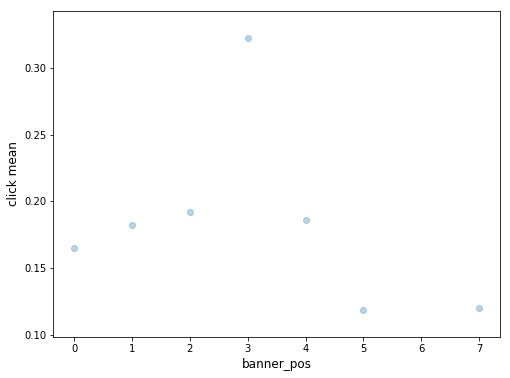

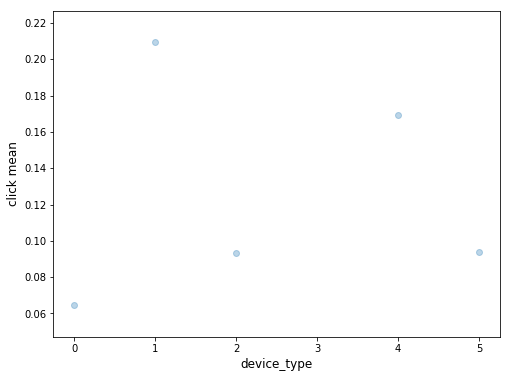

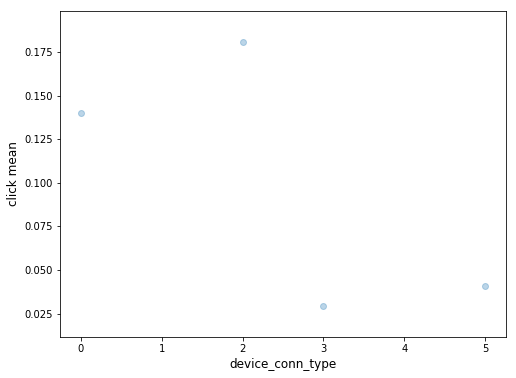

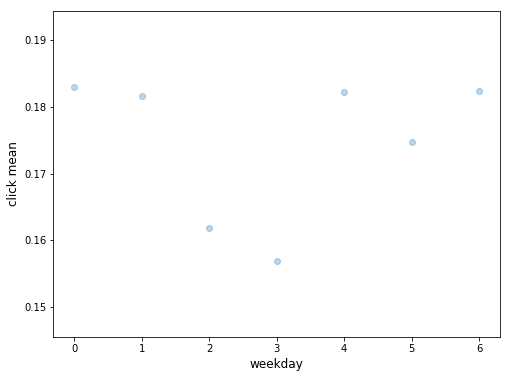

In [23]:
import matplotlib.pyplot as plt

for c in mean_encoding_cols:
    plt.figure(figsize=(8,6))
    plt.scatter(train[c].unique(), train.groupby(c).click.mean(), alpha=0.3)
    plt.xlabel(c, fontsize=12)
    plt.ylabel('click mean', fontsize=12)
    plt.show()

In [24]:
for c in train.columns:
    print('%s: %d' % (c,len(train[c].unique())))
    if len(train[c].unique()) < 10:
        print(train[c].value_counts().to_frame())

id: 36057657
click: 2
      click
0  30059148
1   6150881
hour: 216
C1: 7
            C1
1005  33167984
1002   2034673
1010    856378
1012    103184
1007     32858
1001      9233
1008      5719
banner_pos: 7
   banner_pos
0    25864059
1    10279821
7       40088
2       11531
4        6929
5        5710
3        1891
site_id: 4642
site_domain: 7564
site_category: 26
app_id: 8291
app_domain: 548
app_category: 36
device_id: 2484613
device_ip: 6134351
device_model: 8162
device_type: 5
   device_type
1     33318947
0      2034673
4       734952
5       121426
2           31
device_conn_type: 4
   device_conn_type
0          31333460
2           2817938
3           2018442
5             40189
C14: 2470
C15: 8
           C15
320   33765751
300    2078408
216     289116
728      67987
120       3050
1024      2244
480       2021
768       1452
C16: 9
           C16
50    34128296
250    1618659
36      289116
480      97204
90       67987
20        3050
768       2244
320       2021
1024    

#### get X matrix and y labels for random forest

In [25]:
def train_cats(df):
    data = df.copy()
    for n,c in data.items():
        if c.dtype.name == 'category':
            data[n] = c.cat.as_ordered().cat.codes
    return data

In [26]:
X_train, y_train = train_cats(train.drop(['id', 'click'], axis = 1)), train.click
X_val, y_val = train_cats(val.drop(['id', 'click'], axis = 1)), val.click
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((36210029, 28), (4218938, 28), (36210029,), (4218938,))

#### tune hyperparameters

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

np.random.seed(42)
sample_sz = 10000
rnd_idxs = np.random.permutation(X_train.shape[0])[:sample_sz]

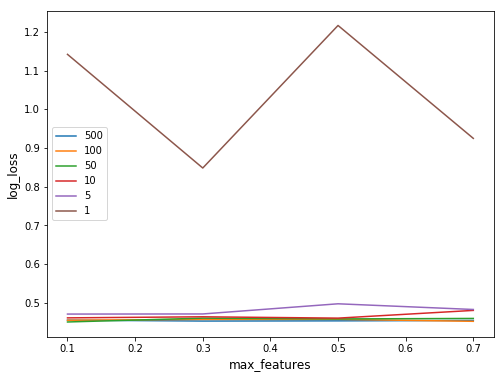

CPU times: user 2min 18s, sys: 31.5 s, total: 2min 50s
Wall time: 1min 14s


In [28]:
%%time
max_features=[0.1, 0.3, 0.5, 0.7]
min_samples_leaf= [500, 100, 50, 10, 5, 1]

plt.figure(figsize=(8,6))

mylist = []
for j in min_samples_leaf:
    x = []
    for i in max_features:
        clf = RandomForestClassifier(n_jobs=-1, n_estimators=10, max_features=i, min_samples_leaf=j)
        clf.fit(X_train.iloc[rnd_idxs], y_train[rnd_idxs])
        dic = {'max_features':i, 'min_samples_leaf':j, 'log_loss':log_loss(y_val, clf.predict_proba(X_val)[:,1])}
        mylist.append(dic)
        x.append(dic['log_loss'])
    plt.plot(max_features,x, label=str(j))

plt.xlabel('max_features', fontsize=12)
plt.ylabel('log_loss', fontsize=12)
plt.legend(loc='best')
plt.show()

In [29]:
pd.DataFrame(mylist, columns=['max_features', 'min_samples_leaf', 'log_loss']).sort_values('log_loss')

,max_features,min_samples_leaf,log_loss
8,0.1,50,0.450755
7,0.7,100,0.452448
1,0.3,500,0.453142
2,0.5,500,0.453631
3,0.7,500,0.454707
4,0.1,100,0.455239
0,0.1,500,0.455561
5,0.3,100,0.457461
6,0.5,100,0.457564
10,0.5,50,0.458627


According to the results above, I will choose `max_features=0.3` and `min_samples_leaf=500` for the sake of both performance and speed to run the final model.

#### fit the final data

In [30]:
%%time
clf = RandomForestClassifier(n_jobs=-1, n_estimators=10, max_features=0.3, min_samples_leaf=500)
clf.fit(X_train, y_train)

CPU times: user 1h 29min 59s, sys: 1min 43s, total: 1h 31min 42s
Wall time: 16min 46s


In [31]:
%time print('logloss on training set: %f \nlogloss on validation set: %f' % \
            (log_loss(y_train, clf.predict_proba(X_train)[:,1]),log_loss(y_val, clf.predict_proba(X_val)[:,1])))

logloss on training set: 0.391406 
logloss on validation set: 0.406370
CPU times: user 2min 18s, sys: 28.2 s, total: 2min 46s
Wall time: 1min 3s
